# Problem set 10
## "The adventure of the 2001 dimensions"
### Zachary Miller

## Part 1: Reproducing Watson's K-means results
We want to impliment a hard k-means clustering on the log counts of Watson's data. To do so, we will use the hard k-means clustering algorithm we wrote for pset 5. Running it below...

In [1]:
import numpy as np
import pandas as pd
import random
from scipy.spatial import distance
from scipy import linalg
import matplotlib.pyplot as plt
import seaborn as sns

random.seed(42)

%matplotlib inline

In [2]:
def hard_k_means_cluster(k, data, N, thresh):
    """Function to impliment k-means clustering with k clusters on a 2d numpy array of data, formatted such that 
    each row is a single c-dimensional data point, where c is the number of columns"""
    num_rows = data.shape[0]
    num_cols = data.shape[1]
    
    best_total_sqr_dist = -1
    best_cluster_centroids = -1
    best_cluster_labels = -1
    
    min_max_list = []
    cluster_trial_sqr_dist_list = []
    
    # Get the min and max of data dimension
    for c in range(num_cols):
        min_max_list.append((data[:,c].min(), data[:,c].max()))
    
    cluster_trial = 0
    while cluster_trial < N:
        # Initiate random centroids
        centroids = np.ones((k, num_cols))
        old_centroids = np.ones((k, num_cols))
        cluster_labels = -1

        # Create k random centroids with dimension values within the range of each data dimension
        for r in range(k):
            for c in range(num_cols):
                centroids[r,c] = random.uniform(min_max_list[c][0],min_max_list[c][1])   
                    
        # Create a list to keep track of the distances
        best_iteration_dist = -1
        for iteration in range(20):
            
            ### Update the clusters###

            # Initiate an array where each index holds the new cluster identity of the data at the correspoinding row
            # index
            new_labels = np.ones(num_rows, dtype=int)
            
            # Iterate over each row of the data
            for r in range(num_rows):
                
                # Get the identity closest centroid to data vector r
                centroid_dists = [distance.euclidean(i,data[r,:]) for i in centroids]
                closest_centroid = np.argmin(centroid_dists)

                # Add the centroid indentity to the array new_clusters
                new_labels[r] = closest_centroid

            ### Update the centroid values###
            iteration_dist = 0
            old_centroids = centroids.copy()
            
            for label in np.unique(new_labels):
                # get all the points belonging to that cluster
                cluster_data_idx = (new_labels == label)
                cluster_data = data[cluster_data_idx,:]
                
                # set the centroid equal to the mean of that cluster
                if len(cluster_data) != 0:
                    centroids[label,:] = np.mean(cluster_data, axis=0)
                    
                else: centroids[label,:] = data[np.random.choice(num_rows,size=1), :] 
                    
            cluster_labels = new_labels
            
            # Check for centroid convergence
            diff = ((centroids - old_centroids) ** 2).mean()
            if diff <= thresh and iteration != 0: 
                break
                
        
        # If a cluster has no labels, do not update
        if len(np.unique(cluster_labels)) == k:
            total_sqr_dist = 0

            for centroid_idx, centroid in enumerate(centroids):
                for r_idx in range(num_rows):
                    if cluster_labels[r_idx] == centroid_idx:
                        total_sqr_dist += distance.euclidean(data[r_idx,:], centroid)**2

            cluster_trial_sqr_dist_list.append(total_sqr_dist)
            
            # Check to see if this run had a lower total squared distance and update the best values if it did            
            if (cluster_trial_sqr_dist_list[-1] < best_total_sqr_dist) or (best_total_sqr_dist == -1):
                best_total_sqr_dist = cluster_trial_sqr_dist_list[-1]
                best_cluster_centroids = centroids
                best_cluster_labels = cluster_labels
            
#             print("Clustering successful")
            cluster_trial +=1

        else: 
#             print("Empty cluster, trying again")
            continue

    return best_cluster_centroids, best_cluster_labels, best_total_sqr_dist, cluster_trial_sqr_dist_list


In [3]:
# Get the log counts of the data and cluster with k-means
data = pd.read_csv("w10-data.tbl", delim_whitespace=True)
log_data_arr = np.log(data.values)
centroids, cluster_labels, sqr_dist, sqr_dist_list = hard_k_means_cluster(8, log_data_arr, 10, 10**(-6))

In [4]:
print("Best total squared distance: " + str(sqr_dist))

Best total squared distance: 88074.55647561594


Taking a look at our total squared distance, we can see that we get a similar number to Watson, so we are confident that we have implimented it correctly.

## Part 2: Running PCA on Watson's data
In order to visualize the 2001 dimensional dataset, we will use PCA to plot the data in two dimensions according to the two largest principle components. We will impliment PCA using singular value decomposition. In addition to ploting the data in PCA space, we also want to see which genes are contribuing the most to cell identity, so we will plot the eigenvector loadings to create a biplot. Lastly, we will create a scree plot of the eigenvalues for Watson's data and some negative control data to make sure we aren't missing any clusters by projecting in to 2D space. Doing so below...

In [5]:
def PCA(data_arr, n):
    """Takes in a non-standardized data array and performs PCA using SVD. Data should be in tidy format,
    with rows as observations and columns as variables"""
    num_rows = data_arr.shape[0]
    # Center the data
    centroid = np.mean(data_arr, axis=0)
    X_star = data_arr-centroid
    
    # Do SVD
    U, s, V_T = linalg.svd(X_star)
    eig_vectors = np.transpose(V_T)
    eig_vals = np.divide(s**2, num_rows-1)
    
    # Get the data projected into the number of PCA components specified
    PCA_data = np.matmul(X_star, eig_vectors[:,0:(n)])
    
    return PCA_data, eig_vectors, eig_vals, s, U, centroid

def PCA_plots(PCA_data, eig_vectors, eig_vals, labels, control_eig_vals):
    """Creates a biplot for the PCA data in 2d, plus a scree plot of the variation captured by each principle
    component for Watson's data and negative control data"""
    
    ### Plot the biplot ###
    PC1 = PCA_data[:,0]
    PC2 = PCA_data[:,1]
    num_dims = eig_vectors.shape[0]
    
    x_scale = np.true_divide(1,(max(PC1) - min(PC1)))
    y_scale = np.true_divide(1,(max(PC2) - min(PC2)))
    eig_vectors_weight = [np.linalg.norm(eig_vectors[i,0:2]) for i in range(num_dims)]
    
    plt.figure(figsize=(15,15))
    plt.scatter(PC1*x_scale, PC2*y_scale)
    
    for i in range(num_dims):
        plt.arrow(0, 0, eig_vectors[i,0], eig_vectors[i,1], color = 'g', alpha=0.4)
        if labels != None:
            if eig_vectors_weight[i] > 0.1:
                plt.text(eig_vectors[i,0]* 1.15, eig_vectors[i,1] * 1.15, labels[i], color = 'r',
                         ha = 'center', va = 'center', alpha=0.8)
    plt.title("Biplot for first 2 PCs (normalized)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
            
    ### Plot the scree plot ###         
    plt.figure(figsize=(15,10))
    plt.plot(eig_vals)
    plt.plot(control_eig_vals)
    plt.title("Scree plot for Watson and negative control data eigenvalues")
    plt.xlabel("# PCs")
    plt.ylabel("Eigenvalue")
    plt.legend(["Watson's data", "Negative control data"])
    
    # return the eigenvalue loadings for future use
    return np.asarray(eig_vectors_weight)

    
def plot_clusters(data, cluster_labels, centroids):
    """Plots a 2d array of data with each row as an observation colored according to the labels in 
    cluster_labels"""
    
    plt.figure(figsize=(15,15))
    clusters = np.unique(cluster_labels)
    
    for cluster in clusters:
        plot_data_idx = (cluster_labels == cluster)
        plot_data = data[plot_data_idx,:]
        plt.scatter(plot_data[:,0], plot_data[:,1], marker='o', alpha=0.8)
    
    plt.scatter(centroids[:,0], centroids[:,1], marker='*', c='k')
    
    plt.title("K-means clustering of data")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    
    return None

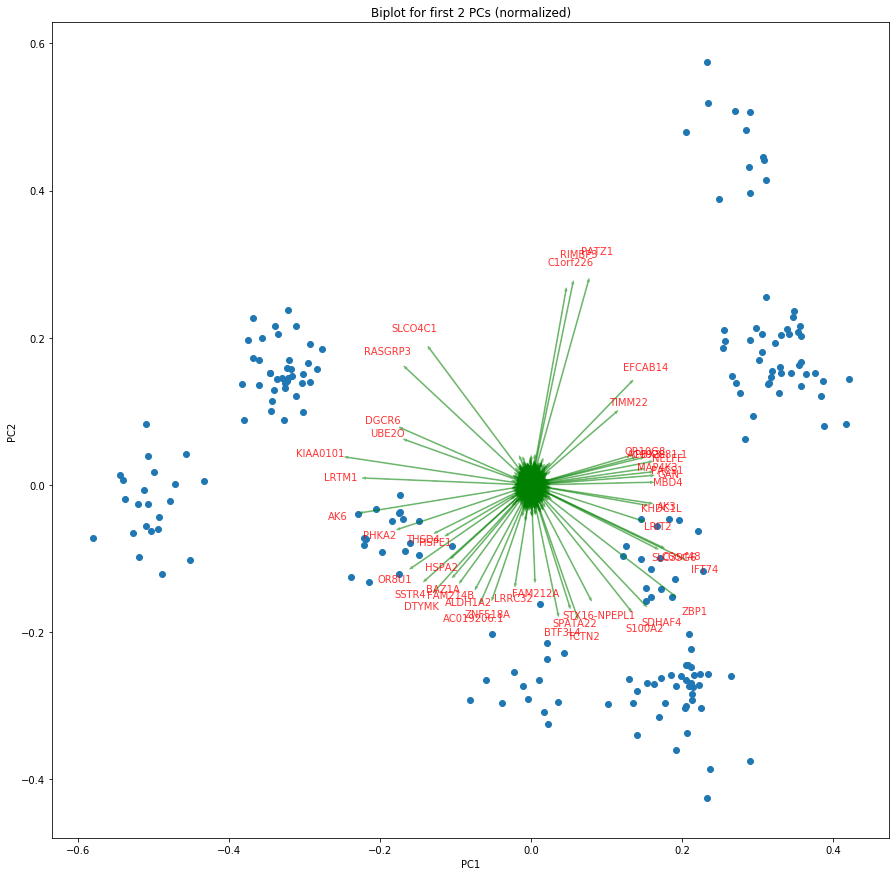

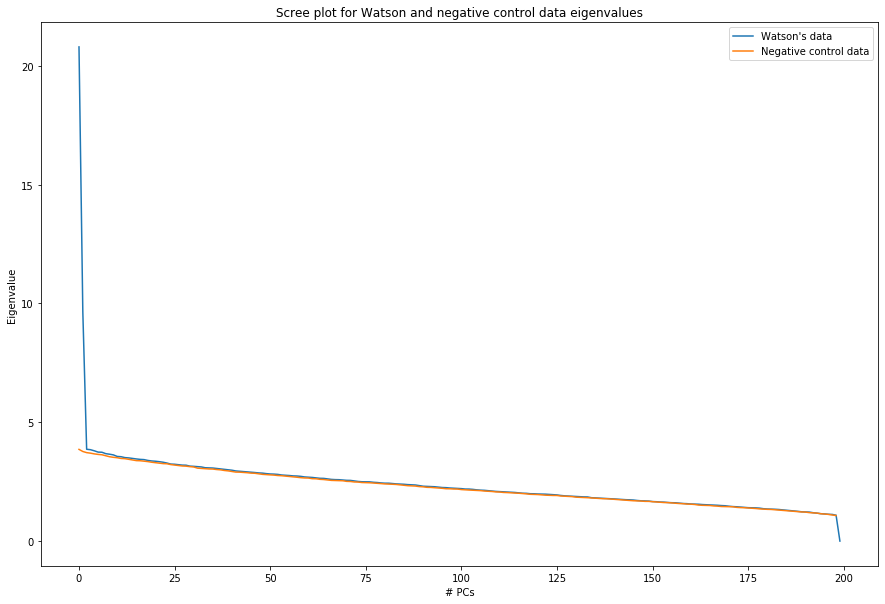

In [6]:
# Get gene names and negative control data
labels_list = list(data.head())
neg_control_data = pd.read_csv("w10-eigen.tbl", header=None, index_col=0, delim_whitespace=True)

# Perform PCA
PCA_data, eig_vectors, eig_vals, s, U, star_centroid = PCA(log_data_arr, 8) 

# Plot the results
eig_vectors_weight = PCA_plots(PCA_data, eig_vectors, eig_vals, labels_list, neg_control_data.values)

Looking at the biplot, we can see that there are 8 distinct clusters in the first two dimensions of PCA space. However, we need to double check that we are not missing some clusters hidden in a higher dimension by looking at the scree plot. Indeed, we see that only the first two eigenvalues are greater than those that would have been generated by a random data matrix. Therefore, we beleive that only the first two principle componenets contain signal, while the other 198 are just capturing noise. This means that all of the clusters should show up in our first two principle components. 

Looking back at our biplot, we can also see that a small subset of the genes seem to be contribing to the first two principle components much more than the others. The genes that have eigenvector loadings of greater than 0.1 are labeled in the plot. We can use the angles between these labeled vectors to understand how they are related to eachother and the principle componenets. A full list of these genes is printed below.

In [7]:
labels_arr = np.asarray(labels_list)
got_arr = eig_vectors_weight > 0.1
print("There are " + str(sum(got_arr)) + " genes with loadings > 0.1, they are: ")
print(labels_arr[got_arr])

There are 47 genes with loadings > 0.1, they are: 
['EFCAB14' 'BTF3L4' 'S100A2' 'C1orf226' 'RASGRP3' 'MAP4K3' 'AC019206.1'
 'HSPE1' 'DTYMK' 'FAM212A' 'LRTM1' 'MBD4' 'AK6' 'SLCO4C1' 'C6orf48'
 'NELFE' 'SDHAF4' 'KHDC1L' 'PHKA2' 'AK3' 'IFT74' 'FAM214B' 'PBX3' 'OR8U1'
 'PACS1' 'LRRC32' 'OR10G8' 'LRIT2' 'ZNF518A' 'AC092881.1' 'TCTN2' 'BAZ1A'
 'HSPA2' 'ALDH1A2' 'KIAA0101' 'THSD4' 'GAN' 'TIMM22' 'SPATA22' 'SLC35G6'
 'UBE2O' 'SSTR4' 'ZBP1' 'STX16-NPEPL1' 'RIMBP3' 'DGCR6' 'PATZ1']


## Part 3: Fixing k-means clustering
Now let's see how the k-means cluster we found in part 1 show up in PC space.

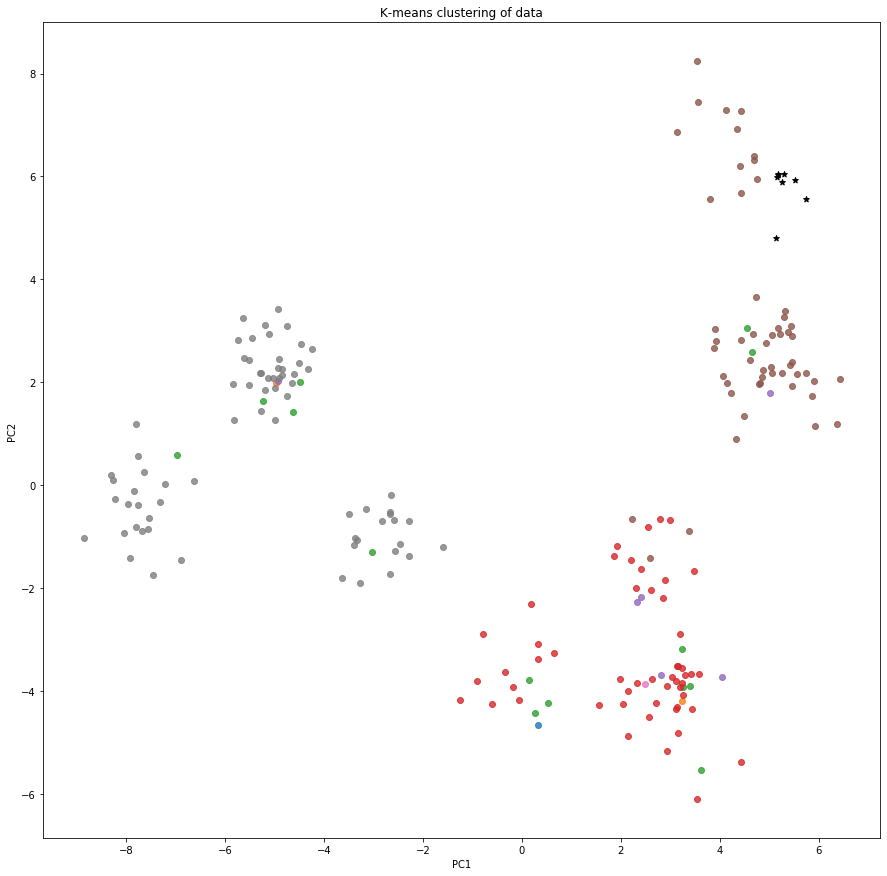

In [8]:
plot_clusters(PCA_data, cluster_labels, centroids)

Clearly clustering the high dimensional data using k-means does not find the clusters of interest. This is likely because, as we saw from our biplot and scree plot, only 47 of the 2001 genes contain truley contain large amounts of signal with respect to the clusters we are interested in. In other words, most of our dimensions we are clustering in are almost entirely noise, so it is going to be much harder for k-means to find the proper centroids with respect to our clusters. 

One way we can fix this is by clustering the data in the first two dimensions of PC space, since we already know that the clusters show up very clearly in this space. Doing this is just a simple k-means clustering problem in 2D. Running k-means on the data projected onto the first two dimensions of PC space and re-plotting below...

In [9]:
pca_centroids, pca_cluster_labels, pca_sqr_dist, test = hard_k_means_cluster(8, 
                                                                      np.asarray(PCA_data[:,0:2]), 15, 10**(-6))

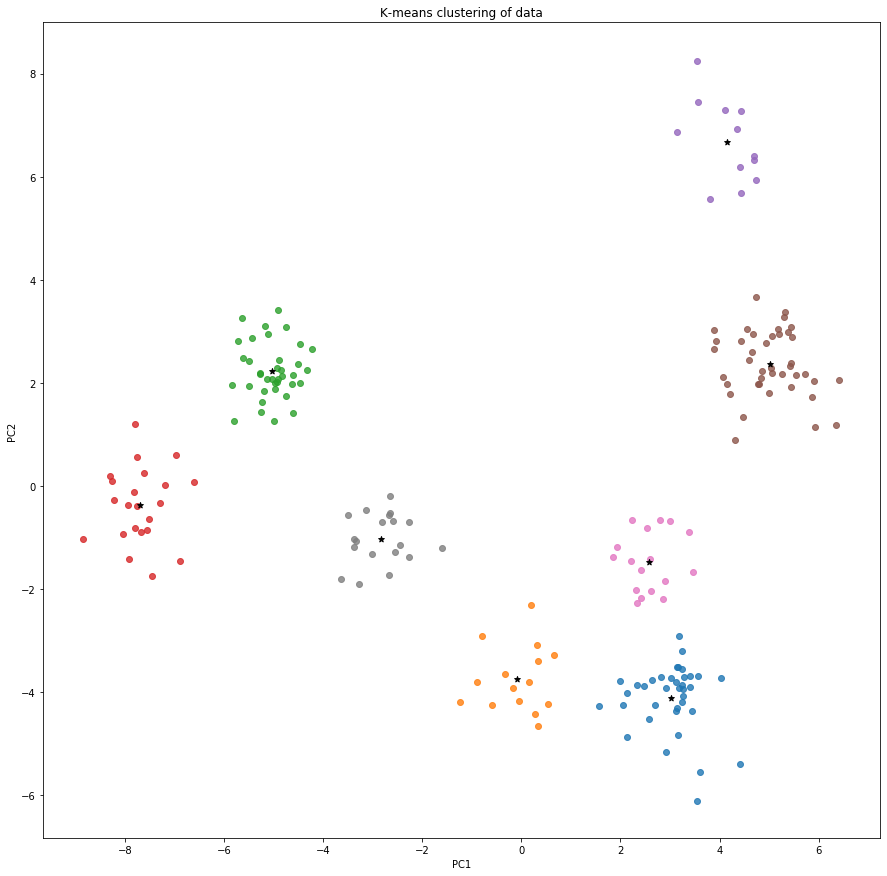

In [10]:
plot_clusters(PCA_data[:,0:2], pca_cluster_labels, pca_centroids)

These clusters obviously look much better.

## Part 4: Reconstructing the data from the PCs
Finally we want to reconstruct our data from the first 2 PCs to get a denoised version of the data. Since we used SVD too perform PCA, we can do this easily by taking the proper columns and rows of our V, U, and S matrices, multiplying them together, and then adding back in the column means to each column of the resulting matrix. Doing so below and plotting a heatmap of the resulting matrix...

In [11]:
def reconstruct_pca_data(X_star, centroid, V, s, U, q):
    S_mat = np.diag(s[0:q])
    V_T = np.transpose(V[:,0:q])
#     Y = np.matmul(U[:,0:q],S_mat)
    a = np.matmul(U[:,0:q],S_mat)
    X_star_q = np.matmul(a, V_T)
    X_q = X_star_q + centroid[np.newaxis,:]
    
    return X_q

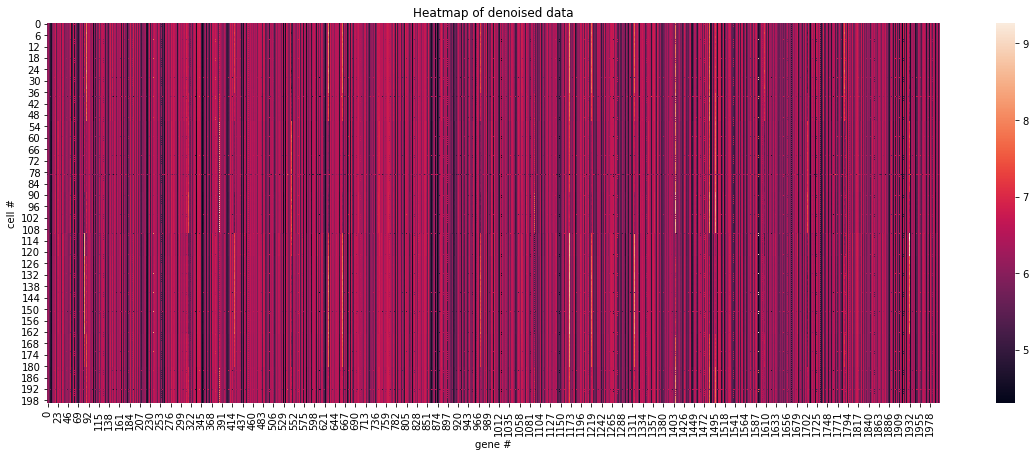

In [12]:
pc_heatmap_data = reconstruct_pca_data(PCA_data, star_centroid, eig_vectors, s, U, 2)

cleaned_genes_data_list = []

for label in np.unique(pca_cluster_labels):
    cluster_data_idx = (pca_cluster_labels == label)
    cluster_data = pc_heatmap_data[cluster_data_idx,:]
    
    cleaned_genes_data_list.append(cluster_data)
    
cleaned_data = np.vstack(cleaned_genes_data_list)

plt.figure(figsize=(20,7))
sns.heatmap(cleaned_data)
plt.title("Heatmap of denoised data")
plt.xlabel("gene #")
plt.ylabel("cell #")
plt.show()

This heatmap is not any clearer than the one we saw from Watson. However, if we think back to our analysis of the loadings of the eigenvectors, we remember that we found only 47 genes that contributed significantly to the first two PCs, with the rest being much less significant. Therefore, we should not be suprised that we cannot see our clusters in the heatmap with all 2001 genes if only 47 of them will vary significantly by cluster. 

However, we should be able to see the difference between the clusters if we create the heatmap but only for the 47 genes that we identified earlier. Plotting below...

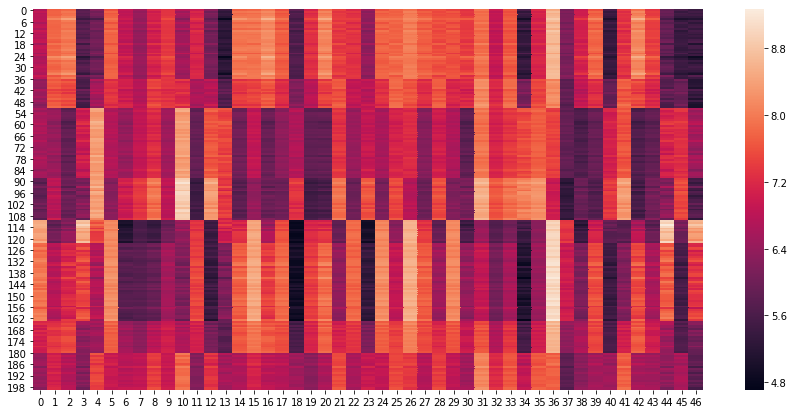

In [13]:
important_genes_idx = eig_vectors_weight > 0.1
# cleaned_genes_data_rd_list = []

# for label in np.unique(pca_cluster_labels):
#     cluster_data_idx = (pca_cluster_labels == label)
#     cluster_data_rd = pc_heatmap_data[cluster_data_idx,:]
#     cluster_data_rd = cluster_data_rd[:,important_genes_idx]
    
#     cleaned_genes_data_list.append(cluster_data_rd)
    
cleaned_data_rd = cleaned_data[:,important_genes_idx]
plt.figure(figsize=(15,7))
sns.heatmap(cleaned_data_rd)
plt.show()

Looking at this new heatmap, we can clearly see 8 distinct expression patterns for these 47 genes among these 200 cells.